# Training & Testing Menggunakan CUHK03

Link Dataset

CUHK03
https://github.com/zhunzhong07/person-re-ranking/tree/master/CUHK03-NP


# Training

### Data

In [ ]:
import os
import math
import copy
import shutil

import pandas as pd
import numpy as np

import time

from tempfile import TemporaryDirectory

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torchvision import transforms, datasets
import torchvision
from torchvision.models import resnet18, ResNet18_Weights, resnet34, ResNet34_Weights, resnet50, ResNet50_Weights, resnext50_32x4d, ResNeXt50_32X4D_Weights
from torch.cuda.amp import GradScaler, autocast
from torchsummary import summary
from torch.autograd import Variable

from skimage.io import imread

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, average_precision_score

In [ ]:
dataset_path = "/content/cuhk03-np/"
if os.path.exists(dataset_path):
    shutil.rmtree(dataset_path)

In [ ]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')

# # Path to the zip file in your Google Drive
zip_file_path = '/content/drive/My Drive/Semester 6/Deep/Proyek/Dataset/cuhk03-np.zip'

# Directory to extract the contents of the zip file
extracted_dir_path = '/content/'

# Create a directory if it doesn't exist
os.makedirs(extracted_dir_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

print("Zip file has been extracted successfully.")

extracted_files = os.listdir(extracted_dir_path)

Mounted at /content/drive
Zip file has been extracted successfully.


In [ ]:
import os
from shutil import copyfile

download_path = '/content/cuhk03-np/detected'

if not os.path.isdir(download_path):
    print('please change the download_path')

save_path = download_path + '/pytorch'
if not os.path.isdir(save_path):
    os.mkdir(save_path)

#-----------------------------------------
#query
query_path = download_path + '/query'
query_save_path = download_path + '/pytorch/query'
if not os.path.isdir(query_save_path):
    os.mkdir(query_save_path)

for root, dirs, files in os.walk(query_path, topdown=True):
    for name in files:
        if not name[-3:]=='png':
            continue
        ID  = name.split('_')
        src_path = query_path + '/' + name
        dst_path = query_save_path + '/' + ID[0]
        if not os.path.isdir(dst_path):
            os.mkdir(dst_path)
        copyfile(src_path, dst_path + '/' + name)

#---------------------------------------
#gallery
gallery_path = download_path + '/bounding_box_test'
gallery_save_path = download_path + '/pytorch/gallery'
if not os.path.isdir(gallery_save_path):
    os.mkdir(gallery_save_path)

for root, dirs, files in os.walk(gallery_path, topdown=True):
    for name in files:
        if not name[-3:]=='png':
            continue
        ID  = name.split('_')
        src_path = gallery_path + '/' + name
        dst_path = gallery_save_path + '/' + ID[0]
        if not os.path.isdir(dst_path):
            os.mkdir(dst_path)
        copyfile(src_path, dst_path + '/' + name)

#---------------------------------------
#train_all
train_path = download_path + '/bounding_box_train'
train_save_path = download_path + '/pytorch/train_all'
if not os.path.isdir(train_save_path):
    os.mkdir(train_save_path)

for root, dirs, files in os.walk(train_path, topdown=True):
    for name in files:
        if not name[-3:]=='png':
            continue
        ID  = name.split('_')
        src_path = train_path + '/' + name
        dst_path = train_save_path + '/' + ID[0]
        if not os.path.isdir(dst_path):
            os.mkdir(dst_path)
        copyfile(src_path, dst_path + '/' + name)

#---------------------------------------
#train_val
train_path = download_path + '/bounding_box_train'
train_save_path = download_path + '/pytorch/train'
val_save_path = download_path + '/pytorch/val'
if not os.path.isdir(train_save_path):
    os.mkdir(train_save_path)
    os.mkdir(val_save_path)

for root, dirs, files in os.walk(train_path, topdown=True):
    for name in files:
        if not name[-3:]=='png':
            continue
        ID  = name.split('_')
        src_path = train_path + '/' + name
        dst_path = train_save_path + '/' + ID[0]
        if not os.path.isdir(dst_path):
            os.mkdir(dst_path)
            dst_path = val_save_path + '/' + ID[0]
            os.mkdir(dst_path)
        copyfile(src_path, dst_path + '/' + name)

In [ ]:
print(len(os.listdir("/content/cuhk03-np/detected/pytorch/train")))
print(len(os.listdir("/content/cuhk03-np/detected/pytorch/gallery")))
print(len(os.listdir("/content/cuhk03-np/detected/pytorch/query")))

767
700
700


In [ ]:
# Untuk train-test split 50:50, bagian ini tidak dirun

def move_files(src_path, dst_path, split_percentage):
    if not os.path.isdir(dst_path):
        os.makedirs(dst_path)

    class_folders = os.listdir(src_path)
    num_classes = len(class_folders)

    num_train_classes = int(num_classes * split_percentage)
    train_classes = class_folders[:num_train_classes]

    for class_folder in train_classes:
        if class_folder == '-1':
            continue
        src_class_path = os.path.join(src_path, class_folder)
        dst_class_path = os.path.join(dst_path, class_folder)
        shutil.move(src_class_path, dst_class_path)

        src_image_path = os.path.join(dst_class_path, os.listdir(dst_class_path)[0])
        dst_val_class_path = os.path.join(val_save_path, class_folder)
        if not os.path.exists(dst_val_class_path):
            os.makedirs(dst_val_class_path)
        shutil.move(src_image_path, dst_val_class_path)

In [ ]:
# Untuk train-test split 50:50, bagian ini tidak dirun

def filter_query(src_path, reference_classes):
    query_folders = os.listdir(src_path)
    for query_folder in query_folders:
        if query_folder not in reference_classes:
            shutil.rmtree(os.path.join(src_path, query_folder))

In [ ]:
# Untuk train-test split 50:50, bagian ini tidak dirun

gallery_path = '/content/cuhk03-np/detected/pytorch/gallery'
query_path = '/content/cuhk03-np/detected/pytorch/query'

split_percentage = 0.58

move_files(gallery_path, train_save_path, split_percentage)

print(len(os.listdir("/content/cuhk03-np/detected/pytorch/train")))
print(len(os.listdir("/content/cuhk03-np/detected/pytorch/val")))
print(len(os.listdir("/content/cuhk03-np/detected/pytorch/gallery")))

reference_classes = os.listdir(gallery_path)
filter_query(query_path, reference_classes)
print(len(os.listdir("/content/cuhk03-np/detected/pytorch/query")))

1173
1173
294
294


In [ ]:
h, w = 256, 128
data_dir = '/content/cuhk03-np/detected/pytorch/'
batchsize = 32
num_epochs = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
transform_train_list = [
    transforms.Resize((h, w), interpolation=3),
    transforms.Pad(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]

transform_val_list = [
    transforms.Resize(size=(h, w), interpolation=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]

data_transforms = {
    'train': transforms.Compose(transform_train_list),
    'val': transforms.Compose(transform_val_list),
}

image_datasets = {}
image_datasets['train'] = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                               data_transforms['train'])
image_datasets['val'] = datasets.ImageFolder(os.path.join(data_dir, 'val'),
                                             data_transforms['val'])

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batchsize, shuffle=True, num_workers=2, pin_memory=True)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(len(class_names))

1173


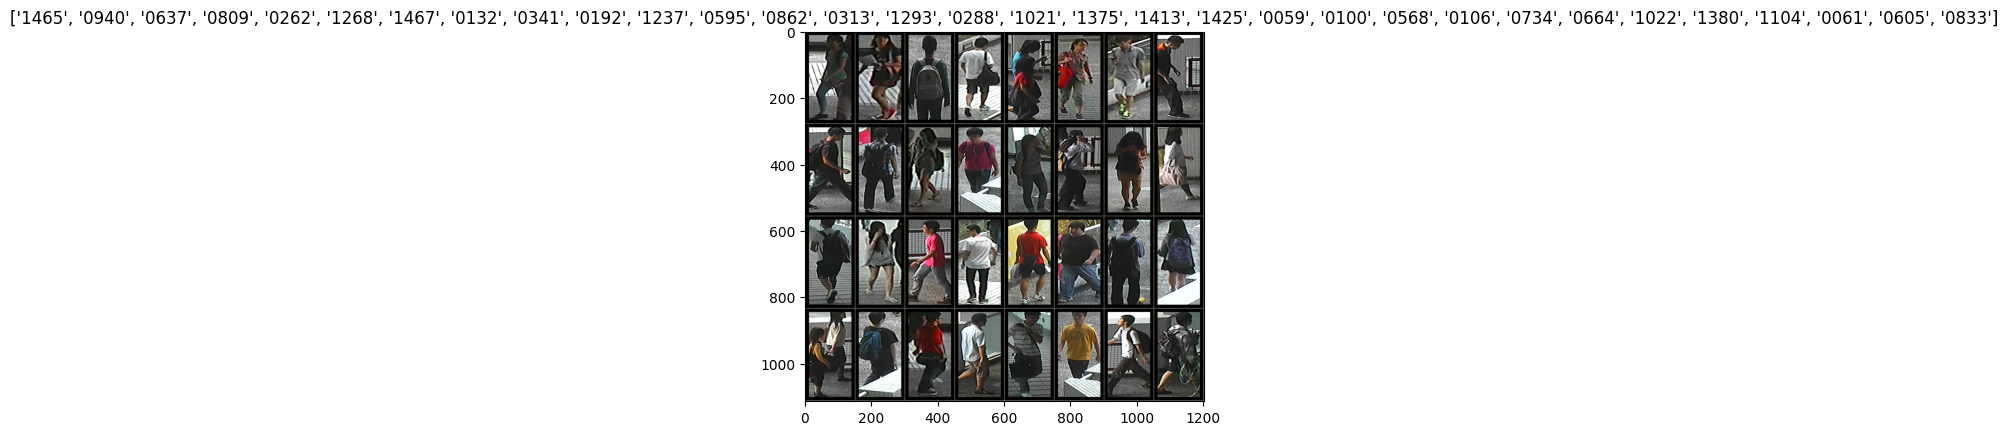

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


In [ ]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, save_dir, save_train_name, save_best_name, num_epochs=25, start_epoch=0,):
    since = time.time()

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    save_train = os.path.join(save_dir, save_train_name)
    save_best = os.path.join(save_dir, save_best_name)

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0
        scaler = GradScaler()

        if start_epoch > 0:
          if os.path.exists(save_best):
            model.load_state_dict(torch.load(save_best))
          else:
            model.load_state_dict(torch.load(save_train))
          print(f"Resuming training from epoch {start_epoch}")

        for epoch in range(start_epoch, num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with autocast():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            scaler.scale(loss).backward()
                            scaler.step(optimizer)
                            scaler.update()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                torch.save(model.state_dict(), save_train)

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)
                    torch.save(model.state_dict(), save_best)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [ ]:
def train_model_no_gs(model, dataloaders, criterion, optimizer, scheduler, save_dir, save_train_name, save_best_name, num_epochs=25, start_epoch=0,):
    since = time.time()

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    save_train = os.path.join(save_dir, save_train_name)
    save_best = os.path.join(save_dir, save_best_name)

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        if start_epoch > 0:
          if os.path.exists(save_best):
            model.load_state_dict(torch.load(save_best))
          else:
            model.load_state_dict(torch.load(save_train))
          print(f"Resuming training from epoch {start_epoch}")

        for epoch in range(start_epoch, num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                torch.save(model.state_dict(), save_train)

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)
                    torch.save(model.state_dict(), save_best)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
save_dir = '/content/drive/My Drive/Proyek_Deep/Model/'

### ResNet18

In [ ]:
modelResnet18 = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

num_ftrs = modelResnet18.fc.in_features
modelResnet18.fc = nn.Linear(num_ftrs, len(class_names))
modelResnet18.to(device)

modelResnet18.eval()

criterion = nn.CrossEntropyLoss()

# optimizer_ft = optim.SGD(modelResnet18.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.AdamW(modelResnet18.parameters(), lr=0.0002, weight_decay=0.015)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
save_dir = '/content/drive/My Drive/Semester 6/Deep/Proyek/Model/'
save_train = 'train_resnet18_cuhk03.pt'
save_best = 'best_param_resnet18_cuhk03.pt'

modelResnet18_gs = train_model(modelResnet18, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, save_dir, save_train, save_best, num_epochs=30)

Epoch 0/29
----------
train Loss: 7.4907 Acc: 0.0000
val Loss: 7.1965 Acc: 0.0009

Epoch 1/29
----------
train Loss: 7.0826 Acc: 0.0006
val Loss: 6.8811 Acc: 0.0009

Epoch 2/29
----------
train Loss: 6.7100 Acc: 0.0013
val Loss: 6.5450 Acc: 0.0034

Epoch 3/29
----------
train Loss: 6.3286 Acc: 0.0042
val Loss: 6.2714 Acc: 0.0034

Epoch 4/29
----------
train Loss: 5.7816 Acc: 0.0154
val Loss: 5.8079 Acc: 0.0094

Epoch 5/29
----------
train Loss: 4.9358 Acc: 0.0475
val Loss: 4.9977 Acc: 0.0597

Epoch 6/29
----------
train Loss: 3.8273 Acc: 0.1524
val Loss: 4.7308 Acc: 0.0946

Epoch 7/29
----------
train Loss: 2.2678 Acc: 0.4845
val Loss: 3.0656 Acc: 0.2702

Epoch 8/29
----------
train Loss: 1.7974 Acc: 0.6348
val Loss: 2.8590 Acc: 0.3291

Epoch 9/29
----------
train Loss: 1.5487 Acc: 0.7039
val Loss: 2.6483 Acc: 0.3905

Epoch 10/29
----------
train Loss: 1.3333 Acc: 0.7676
val Loss: 2.5520 Acc: 0.4152

Epoch 11/29
----------
train Loss: 1.1368 Acc: 0.8212
val Loss: 2.4973 Acc: 0.4186

Ep

In [ ]:
save_train = 'train_resnet18_cuhk03_no_gs.pt'
save_best = 'best_param_resnet18_cuhk03_no_gs.pt'

modelResnet18_nogs = train_model_no_gs(modelResnet18, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, save_dir, save_train, save_best, num_epochs=30)

Epoch 0/29
----------
train Loss: 6.7551 Acc: 0.0344
val Loss: 5.4711 Acc: 0.1100

Epoch 1/29
----------
train Loss: 4.3254 Acc: 0.3599
val Loss: 3.6234 Acc: 0.4066

Epoch 2/29
----------
train Loss: 2.2527 Acc: 0.7951
val Loss: 2.4341 Acc: 0.6854

Epoch 3/29
----------
train Loss: 0.8519 Acc: 0.9694
val Loss: 1.5961 Acc: 0.8252

Epoch 4/29
----------
train Loss: 0.2523 Acc: 0.9980
val Loss: 1.3285 Acc: 0.8559

Epoch 5/29
----------
train Loss: 0.0876 Acc: 1.0000
val Loss: 1.1480 Acc: 0.8755

Epoch 6/29
----------
train Loss: 0.0455 Acc: 1.0000
val Loss: 1.1128 Acc: 0.8764

Epoch 7/29
----------
train Loss: 0.0309 Acc: 1.0000
val Loss: 1.1329 Acc: 0.8764

Epoch 8/29
----------
train Loss: 0.0289 Acc: 1.0000
val Loss: 1.1057 Acc: 0.8764

Epoch 9/29
----------
train Loss: 0.0274 Acc: 1.0000
val Loss: 1.0976 Acc: 0.8789

Epoch 10/29
----------
train Loss: 0.0262 Acc: 1.0000
val Loss: 1.0954 Acc: 0.8755

Epoch 11/29
----------
train Loss: 0.0251 Acc: 1.0000
val Loss: 1.0973 Acc: 0.8772

Ep

In [ ]:
visualize_model(modelResnet18)

### ResNet34

In [ ]:
modelResnet34 = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)

num_ftrs = modelResnet34.fc.in_features
modelResnet34.fc = nn.Linear(num_ftrs, len(class_names))
modelResnet34.to(device)

modelResnet34.eval()

criterion = nn.CrossEntropyLoss()

# optimizer_ft = optim.SGD(modelResnet34.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.AdamW(modelResnet34.parameters(), lr=0.0002, weight_decay=0.015)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
save_train = 'train_resnet34_cuhk03.pt'
save_best = 'best_param_resnet34_cuhk03.pt'

modelResnet34_gs = train_model(modelResnet34, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, save_dir, save_train, save_best, num_epochs=30)

Epoch 0/29
----------
train Loss: 6.7594 Acc: 0.0289
val Loss: 5.3054 Acc: 0.1270

Epoch 1/29
----------
train Loss: 4.2040 Acc: 0.2998
val Loss: 3.1546 Acc: 0.4467

Epoch 2/29
----------
train Loss: 1.9372 Acc: 0.7459
val Loss: 1.6998 Acc: 0.7298

Epoch 3/29
----------
train Loss: 0.6390 Acc: 0.9539
val Loss: 1.0132 Acc: 0.8278

Epoch 4/29
----------
train Loss: 0.1638 Acc: 0.9960
val Loss: 0.6497 Acc: 0.9045

Epoch 5/29
----------
train Loss: 0.0516 Acc: 0.9998
val Loss: 0.5193 Acc: 0.9156

Epoch 6/29
----------
train Loss: 0.0260 Acc: 0.9999
val Loss: 0.4978 Acc: 0.9199

Epoch 7/29
----------
train Loss: 0.0178 Acc: 1.0000
val Loss: 0.4920 Acc: 0.9233

Epoch 8/29
----------
train Loss: 0.0166 Acc: 1.0000
val Loss: 0.5019 Acc: 0.9216

Epoch 9/29
----------
train Loss: 0.0159 Acc: 1.0000
val Loss: 0.4934 Acc: 0.9207

Epoch 10/29
----------
train Loss: 0.0151 Acc: 1.0000
val Loss: 0.4931 Acc: 0.9216

Epoch 11/29
----------
train Loss: 0.0142 Acc: 1.0000
val Loss: 0.4883 Acc: 0.9241

Ep

In [ ]:
save_train = 'train_resnet34_cuhk03_no_gs.pt'
save_best = 'best_param_resnet34_cuhk03_no_gs.pt'

modelResnet34_nogs = train_model_no_gs(modelResnet34, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, save_dir, save_train, save_best, num_epochs=30)

Epoch 0/29
----------
train Loss: 7.0181 Acc: 0.0093
val Loss: 6.0033 Acc: 0.0494

Epoch 1/29
----------
train Loss: 4.9247 Acc: 0.1627
val Loss: 3.8007 Acc: 0.2600

Epoch 2/29
----------
train Loss: 2.5612 Acc: 0.5830
val Loss: 2.2175 Acc: 0.5806

Epoch 3/29
----------
train Loss: 1.0013 Acc: 0.8909
val Loss: 1.2950 Acc: 0.7494

Epoch 4/29
----------
train Loss: 0.2970 Acc: 0.9865
val Loss: 0.7543 Acc: 0.8721

Epoch 5/29
----------
train Loss: 0.0878 Acc: 0.9984
val Loss: 0.6091 Acc: 0.8977

Epoch 6/29
----------
train Loss: 0.0372 Acc: 0.9996
val Loss: 0.4859 Acc: 0.9173

Epoch 7/29
----------
train Loss: 0.0221 Acc: 1.0000
val Loss: 0.4725 Acc: 0.9182

Epoch 8/29
----------
train Loss: 0.0202 Acc: 1.0000
val Loss: 0.4969 Acc: 0.9139

Epoch 9/29
----------
train Loss: 0.0186 Acc: 1.0000
val Loss: 0.4849 Acc: 0.9130

Epoch 10/29
----------
train Loss: 0.0177 Acc: 1.0000
val Loss: 0.4762 Acc: 0.9165

Epoch 11/29
----------
train Loss: 0.0165 Acc: 1.0000
val Loss: 0.4659 Acc: 0.9165

Ep

In [ ]:
visualize_model(modelResnet34)

### ResNet50

In [ ]:
modelResnet50 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

num_ftrs = modelResnet50.fc.in_features
modelResnet50.fc = nn.Linear(num_ftrs, len(class_names))
modelResnet50.to(device)

modelResnet50.eval()

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.AdamW(modelResnet50.parameters(), lr=0.0002, weight_decay=0.015)
# optimizer_ft = optim.AdamW(modelResnet50.parameters(), lr=0.001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 75.3MB/s]


In [ ]:
# save_dir = '/content/drive/My Drive/Proyek_deep/Proyek/Model/'
save_train = 'train_resnet50_cuhk03.pt'
save_best = 'best_param_resnet50_cuhk03.pt'

modelResnet50_gs = train_model(modelResnet50, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, save_dir, save_train, save_best, num_epochs=30)

Epoch 0/29
----------
train Loss: 7.1769 Acc: 0.0011
val Loss: 6.9822 Acc: 0.0009

Epoch 1/29
----------
train Loss: 6.7842 Acc: 0.0014
val Loss: 6.5023 Acc: 0.0043

Epoch 2/29
----------
train Loss: 6.2291 Acc: 0.0066
val Loss: 5.7641 Acc: 0.0256

Epoch 3/29
----------
train Loss: 5.0880 Acc: 0.0523
val Loss: 4.5980 Acc: 0.1014

Epoch 4/29
----------
train Loss: 3.3759 Acc: 0.2378
val Loss: 2.8317 Acc: 0.3291

Epoch 5/29
----------
train Loss: 1.8715 Acc: 0.5454
val Loss: 2.0543 Acc: 0.5013

Epoch 6/29
----------
train Loss: 0.8669 Acc: 0.8111
val Loss: 1.4324 Acc: 0.6275

Epoch 7/29
----------
train Loss: 0.3273 Acc: 0.9646
val Loss: 0.8601 Acc: 0.7945

Epoch 8/29
----------
train Loss: 0.2066 Acc: 0.9905
val Loss: 0.8143 Acc: 0.8133

Epoch 9/29
----------
train Loss: 0.1688 Acc: 0.9946
val Loss: 0.7836 Acc: 0.8252

Epoch 10/29
----------
train Loss: 0.1400 Acc: 0.9969
val Loss: 0.7325 Acc: 0.8397

Epoch 11/29
----------
train Loss: 0.1165 Acc: 0.9987
val Loss: 0.7440 Acc: 0.8286

Ep

In [ ]:

save_train = 'train_resnet50_cuhk03_no_gs.pt'
save_best = 'best_param_resnet50_cuhk03_no_gs.pt'

modelResnet50_nogs = train_model_no_gs(modelResnet50, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, save_dir, save_train, save_best, num_epochs=30)

Epoch 0/29
----------
train Loss: 7.1427 Acc: 0.0003
val Loss: 7.0680 Acc: 0.0009

Epoch 1/29
----------
train Loss: 7.0505 Acc: 0.0006
val Loss: 7.1854 Acc: 0.0009

Epoch 2/29
----------
train Loss: 6.9437 Acc: 0.0012
val Loss: 6.9741 Acc: 0.0034

Epoch 3/29
----------
train Loss: 6.8484 Acc: 0.0019
val Loss: 7.0060 Acc: 0.0043

Epoch 4/29
----------
train Loss: 6.5969 Acc: 0.0024
val Loss: 6.8737 Acc: 0.0017

Epoch 5/29
----------
train Loss: 6.2637 Acc: 0.0056
val Loss: 6.3391 Acc: 0.0111

Epoch 6/29
----------
train Loss: 5.6449 Acc: 0.0172
val Loss: 6.5408 Acc: 0.0171

Epoch 7/29
----------
train Loss: 4.9346 Acc: 0.0549
val Loss: 5.8939 Acc: 0.0196

Epoch 8/29
----------
train Loss: 4.7127 Acc: 0.0746
val Loss: 6.0051 Acc: 0.0188

Epoch 9/29
----------
train Loss: 4.4758 Acc: 0.1036
val Loss: 5.5715 Acc: 0.0247

Epoch 10/29
----------
train Loss: 4.1986 Acc: 0.1425
val Loss: 5.4796 Acc: 0.0358

Epoch 11/29
----------
train Loss: 3.8451 Acc: 0.1928
val Loss: 5.3760 Acc: 0.0503

Ep

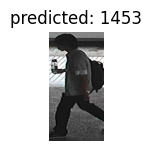

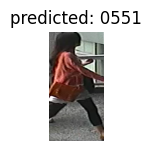

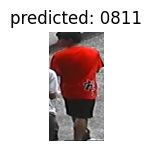

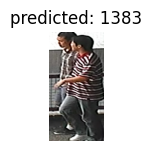

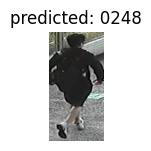

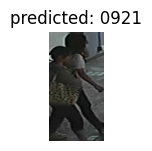

In [ ]:
visualize_model(modelResnet50)

### ResNext50_32x4d

In [ ]:
modelResnext = resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1)

num_ftrs = modelResnext.fc.in_features
modelResnext.fc = nn.Linear(num_ftrs, len(class_names))
modelResnext.to(device)

modelResnext.eval()

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.AdamW(modelResnext.parameters(), lr=0.0002, weight_decay=0.015)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
save_train = 'train_resnext_cuhk03_ft.pt'
save_best = 'best_param_resnext_cuhk03_ft.pt'

modelResnext_gs = train_model(modelResnext, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, save_dir, save_train, save_best, num_epochs=30)

Epoch 0/29
----------
train Loss: 6.6900 Acc: 0.0225
val Loss: 4.8106 Acc: 0.1168

Epoch 1/29
----------
train Loss: 3.5998 Acc: 0.3252
val Loss: 2.1722 Acc: 0.5388

Epoch 2/29
----------
train Loss: 1.2354 Acc: 0.8099
val Loss: 0.9470 Acc: 0.8022

Epoch 3/29
----------
train Loss: 0.2993 Acc: 0.9725
val Loss: 0.5159 Acc: 0.8977

Epoch 4/29
----------
train Loss: 0.0793 Acc: 0.9974
val Loss: 0.3594 Acc: 0.9267

Epoch 5/29
----------
train Loss: 0.0344 Acc: 0.9991
val Loss: 0.3199 Acc: 0.9318

Epoch 6/29
----------
train Loss: 0.0197 Acc: 0.9999
val Loss: 0.2703 Acc: 0.9420

Epoch 7/29
----------
train Loss: 0.0118 Acc: 0.9999
val Loss: 0.2930 Acc: 0.9395

Epoch 8/29
----------
train Loss: 0.0111 Acc: 0.9999
val Loss: 0.2734 Acc: 0.9429

Epoch 9/29
----------
train Loss: 0.0104 Acc: 0.9999
val Loss: 0.2782 Acc: 0.9437

Epoch 10/29
----------
train Loss: 0.0099 Acc: 0.9999
val Loss: 0.2897 Acc: 0.9369

Epoch 11/29
----------
train Loss: 0.0094 Acc: 0.9999
val Loss: 0.2752 Acc: 0.9446

Ep

In [ ]:
save_train = 'train_resnext_cuhk03_no_gs.pt'
save_best = 'best_param_resnext_cuhk03_no_gs.pt'

modelResnext_nogs = train_model_no_gs(modelResnext, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, save_dir, save_train, save_best, num_epochs=30)

Epoch 0/29
----------
train Loss: 6.5317 Acc: 0.0330
val Loss: 4.5129 Acc: 0.1594

Epoch 1/29
----------
train Loss: 3.3680 Acc: 0.3642
val Loss: 2.0627 Acc: 0.5567

Epoch 2/29
----------
train Loss: 1.1267 Acc: 0.8303
val Loss: 0.8786 Acc: 0.8107

Epoch 3/29
----------
train Loss: 0.2581 Acc: 0.9801
val Loss: 0.4965 Acc: 0.9028

Epoch 4/29
----------
train Loss: 0.0673 Acc: 0.9975
val Loss: 0.3563 Acc: 0.9309

Epoch 5/29
----------
train Loss: 0.0290 Acc: 0.9995
val Loss: 0.2946 Acc: 0.9437

Epoch 6/29
----------
train Loss: 0.0191 Acc: 0.9998
val Loss: 0.2847 Acc: 0.9488

Epoch 7/29
----------
train Loss: 0.0110 Acc: 0.9999
val Loss: 0.2861 Acc: 0.9446

Epoch 8/29
----------
train Loss: 0.0104 Acc: 0.9999
val Loss: 0.2722 Acc: 0.9488

Epoch 9/29
----------
train Loss: 0.0100 Acc: 0.9999
val Loss: 0.2742 Acc: 0.9480

Epoch 10/29
----------
train Loss: 0.0094 Acc: 0.9999
val Loss: 0.2775 Acc: 0.9446

Epoch 11/29
----------
train Loss: 0.0091 Acc: 0.9999
val Loss: 0.2865 Acc: 0.9446

Ep

In [ ]:
visualize_model(modelResnext)

# Testing

### Prepare

In [ ]:
transform_test_list = [
    transforms.Resize(size=(h, w), interpolation=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]

data_transforms = {
    'gallery': transforms.Compose(transform_test_list),
    'query': transforms.Compose(transform_test_list),
}

image_datasets = {}
image_datasets['gallery'] = datasets.ImageFolder(os.path.join(data_dir, 'gallery'),
                                               data_transforms['gallery'])
image_datasets['query'] = datasets.ImageFolder(os.path.join(data_dir, 'query'),
                                             data_transforms['query'])

dataloaders_test = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batchsize, shuffle=False, num_workers=2, pin_memory=True)
               for x in ['gallery', 'query']}

dataset_test_sizes = {x: len(image_datasets[x]) for x in ['gallery', 'query']}
test_class_names = image_datasets['gallery'].classes
print(len(test_class_names))

294


In [ ]:
def process_in_batches(loader, model, device, batch_size=32):
    features = []
    labels = []
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(device)
            lbls = lbls.to(device)
            batch_features = []
            batch_labels = []
            for i in range(0, len(imgs), batch_size):
                batch_imgs = imgs[i:i+batch_size]
                batch_lbls = lbls[i:i+batch_size]
                batch_outputs = model(batch_imgs)
                batch_features.append(batch_outputs.cpu().numpy())
                batch_labels.append(batch_lbls.cpu().numpy())
            features.append(np.concatenate(batch_features))
            labels.append(np.concatenate(batch_labels))
    return np.concatenate(features), np.concatenate(labels)

In [ ]:
def compute_mAP_and_CMC(dist_matrix, query_labels, gallery_labels):
    num_query = len(query_labels)
    all_cmc = []
    all_AP = []
    for i in range(num_query):
        distances = dist_matrix[i]
        indices = np.argsort(distances)
        matches = (gallery_labels[indices] == query_labels[i]).astype(int)

        cmc = matches.cumsum()
        cmc[cmc > 1] = 1
        all_cmc.append(cmc)

        precision = matches.cumsum() / (np.arange(len(matches)) + 1)
        all_AP.append((precision * matches).sum() / max(1, matches.sum()))

    all_cmc = np.array(all_cmc).mean(axis=0)
    mAP = np.mean(all_AP)
    return mAP, all_cmc

In [ ]:
def compute_distance_matrix(query_features, gallery_features, batch_size=32):
    num_query = query_features.shape[0]
    num_gallery = gallery_features.shape[0]
    dist_matrix = np.zeros((num_query, num_gallery))

    for i in range(0, num_query, batch_size):
        query_batch = query_features[i:i+batch_size]
        for j in range(0, num_gallery, batch_size):
            gallery_batch = gallery_features[j:j+batch_size]
            query_gallery_dist = np.linalg.norm(query_batch[:, np.newaxis] - gallery_batch, axis=2)
            dist_matrix[i:i+len(query_batch), j:j+len(gallery_batch)] = query_gallery_dist

    return dist_matrix

In [ ]:
def predict(dist_matrix, gallery_class_names):
    predictions = []
    for dist in dist_matrix:
        pred_idx = np.argmin(dist)
        predictions.append(gallery_class_names[pred_idx])
    return predictions

### ResNet18

In [ ]:
modelResnet18_gs = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = modelResnet18_gs.fc.in_features
modelResnet18_gs.fc = nn.Linear(num_ftrs, len(class_names))
modelResnet18_gs.to(device)
modelResnet18_gs.eval()

modelResnet18_gs.load_state_dict(torch.load('/content/drive/My Drive/Semester 6/Deep/Proyek/Model/fine-tuned/best_param_resnet18_cuhk03.pt', map_location=device))
modelResnet18_gs.fc = torch.nn.Linear(num_ftrs, len(test_class_names))

for param_tensor in modelResnet18_gs.state_dict():
    modelResnet18_gs.state_dict()[param_tensor] = modelResnet18_gs.state_dict()[param_tensor].to(device)
modelResnet18_gs.fc.weight.data = modelResnet18_gs.fc.weight.data.to(device)
modelResnet18_gs.fc.bias.data = modelResnet18_gs.fc.bias.data.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 79.7MB/s]


RuntimeError: Error(s) in loading state_dict for ResNet:
	size mismatch for fc.weight: copying a param with shape torch.Size([767, 512]) from checkpoint, the shape in current model is torch.Size([1173, 512]).
	size mismatch for fc.bias: copying a param with shape torch.Size([767]) from checkpoint, the shape in current model is torch.Size([1173]).

In [ ]:
query_features, query_labels = process_in_batches(dataloaders_test['query'], modelResnet18_gs, device)
gallery_features, gallery_labels = process_in_batches(dataloaders_test['gallery'], modelResnet18_gs, device)

dist_matrix = compute_distance_matrix(query_features, gallery_features, batch_size=32)

query_class_names = [image_datasets['query'].classes[label] for label in query_labels]
gallery_class_names = [image_datasets['gallery'].classes[label] for label in gallery_labels]

mAP, cmc = compute_mAP_and_CMC(dist_matrix, query_labels, gallery_labels)
predictions = predict(dist_matrix, gallery_class_names)

print(f'\nmAP: {mAP:.4f}')
print(f'CMC (top-1, top-5, top-10): {cmc[0]:.4f}, {cmc[4]:.4f}, {cmc[9]:.4f}')


mAP: 0.4663
CMC (top-1, top-5, top-10): 0.8248, 0.9473, 0.9694


In [ ]:
modelResnet18_no_gs = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = modelResnet18_no_gs.fc.in_features
modelResnet18_no_gs.fc = nn.Linear(num_ftrs, len(class_names))
modelResnet18_no_gs.to(device)
modelResnet18_no_gs.eval()

modelResnet18_no_gs.load_state_dict(torch.load('/content/drive/My Drive/Proyek/Model/best_param_resnet18_cuhk03_no_gs.pt', map_location=device))
modelResnet18_no_gs.fc = torch.nn.Linear(num_ftrs, len(test_class_names))

for param_tensor in modelResnet18_no_gs.state_dict():
    modelResnet18_no_gs.state_dict()[param_tensor] = modelResnet18_no_gs.state_dict()[param_tensor].to(device)
modelResnet18_no_gs.fc.weight.data = modelResnet18_no_gs.fc.weight.data.to(device)
modelResnet18_no_gs.fc.bias.data = modelResnet18_no_gs.fc.bias.data.to(device)

In [ ]:
query_features, query_labels = process_in_batches(dataloaders_test['query'], modelResnet18_no_gs, device)
gallery_features, gallery_labels = process_in_batches(dataloaders_test['gallery'], modelResnet18_no_gs, device)

dist_matrix = compute_distance_matrix(query_features, gallery_features, batch_size=32)

query_class_names = [image_datasets['query'].classes[label] for label in query_labels]
gallery_class_names = [image_datasets['gallery'].classes[label] for label in gallery_labels]

mAP, cmc = compute_mAP_and_CMC(dist_matrix, query_labels, gallery_labels)
predictions = predict(dist_matrix, gallery_class_names)

print(f'\nmAP: {mAP:.4f}')
print(f'CMC (top-1, top-5, top-10): {cmc[0]:.4f}, {cmc[4]:.4f}, {cmc[9]:.4f}')


mAP: 0.4698
CMC (top-1, top-5, top-10): 0.8503, 0.9541, 0.9694


### ResNet34

In [ ]:
modelResnet34_gs = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
num_ftrs = modelResnet34_gs.fc.in_features
modelResnet34_gs.fc = nn.Linear(num_ftrs, len(class_names))
modelResnet34_gs.to(device)
modelResnet34_gs.eval()

modelResnet34_gs.load_state_dict(torch.load('/content/drive/My Drive/Semester 6/Deep/Proyek/Model/2/best_param_resnet34_cuhk03.pt', map_location=device))
modelResnet34_gs.fc = torch.nn.Linear(num_ftrs, len(test_class_names))

for param_tensor in modelResnet34_gs.state_dict():
    modelResnet34_gs.state_dict()[param_tensor] = modelResnet34_gs.state_dict()[param_tensor].to(device)
modelResnet34_gs.fc.weight.data = modelResnet34_gs.fc.weight.data.to(device)
modelResnet34_gs.fc.bias.data = modelResnet34_gs.fc.bias.data.to(device)

In [ ]:
query_features, query_labels = process_in_batches(dataloaders_test['query'], modelResnet34_gs, device)
gallery_features, gallery_labels = process_in_batches(dataloaders_test['gallery'], modelResnet34_gs, device)

dist_matrix = compute_distance_matrix(query_features, gallery_features, batch_size=32)

query_class_names = [image_datasets['query'].classes[label] for label in query_labels]
gallery_class_names = [image_datasets['gallery'].classes[label] for label in gallery_labels]

mAP, cmc = compute_mAP_and_CMC(dist_matrix, query_labels, gallery_labels)
predictions = predict(dist_matrix, gallery_class_names)

print(f'\nmAP: {mAP:.4f}')
print(f'CMC (top-1, top-5, top-10): {cmc[0]:.4f}, {cmc[4]:.4f}, {cmc[9]:.4f}')


mAP: 0.4428
CMC (top-1, top-5, top-10): 0.7908, 0.9252, 0.9626


In [ ]:
modelResnet34_no_gs = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
num_ftrs = modelResnet34_no_gs.fc.in_features
modelResnet34_no_gs.fc = nn.Linear(num_ftrs, len(class_names))
modelResnet34_no_gs.to(device)
modelResnet34_no_gs.eval()

modelResnet34_no_gs.load_state_dict(torch.load('/content/drive/My Drive/Proyek/Model/best_param_resnet34_cuhk03_no_gs.pt', map_location=device))
modelResnet34_no_gs.fc = torch.nn.Linear(num_ftrs, len(test_class_names))

for param_tensor in modelResnet34_no_gs.state_dict():
    modelResnet34_no_gs.state_dict()[param_tensor] = modelResnet34_no_gs.state_dict()[param_tensor].to(device)
modelResnet34_no_gs.fc.weight.data = modelResnet34_no_gs.fc.weight.data.to(device)
modelResnet34_no_gs.fc.bias.data = modelResnet34_no_gs.fc.bias.data.to(device)

In [ ]:
query_features, query_labels = process_in_batches(dataloaders_test['query'], modelResnet34_no_gs, device)
gallery_features, gallery_labels = process_in_batches(dataloaders_test['gallery'], modelResnet34_no_gs, device)

dist_matrix = compute_distance_matrix(query_features, gallery_features, batch_size=32)

query_class_names = [image_datasets['query'].classes[label] for label in query_labels]
gallery_class_names = [image_datasets['gallery'].classes[label] for label in gallery_labels]

mAP, cmc = compute_mAP_and_CMC(dist_matrix, query_labels, gallery_labels)
predictions = predict(dist_matrix, gallery_class_names)

for i, (query_name, pred_name) in enumerate(zip(query_class_names, predictions)):
    print(f'Query {i+1}: {query_name}, Prediction: {pred_name}')

print(f'\nmAP: {mAP:.4f}')
print(f'CMC (top-1, top-5, top-10): {cmc[0]:.4f}, {cmc[4]:.4f}, {cmc[9]:.4f}')

Query 1: 0006, Prediction: 0006
Query 2: 0006, Prediction: 0006
Query 3: 0011, Prediction: 0578
Query 4: 0011, Prediction: 0011
Query 5: 0028, Prediction: 0028
Query 6: 0028, Prediction: 0562
Query 7: 0032, Prediction: 0174
Query 8: 0032, Prediction: 0032
Query 9: 0033, Prediction: 0261
Query 10: 0033, Prediction: 0033
Query 11: 0038, Prediction: 0038
Query 12: 0038, Prediction: 0038
Query 13: 0041, Prediction: 0041
Query 14: 0041, Prediction: 0041
Query 15: 0042, Prediction: 0042
Query 16: 0042, Prediction: 0042
Query 17: 0045, Prediction: 0045
Query 18: 0045, Prediction: 0045
Query 19: 0047, Prediction: 0047
Query 20: 0047, Prediction: 0047
Query 21: 0051, Prediction: 0051
Query 22: 0051, Prediction: 0051
Query 23: 0062, Prediction: 0062
Query 24: 0062, Prediction: 0062
Query 25: 0069, Prediction: 0069
Query 26: 0069, Prediction: 0069
Query 27: 0074, Prediction: 0074
Query 28: 0074, Prediction: 0074
Query 29: 0078, Prediction: 0078
Query 30: 0078, Prediction: 0078
Query 31: 0081, Pre

### ResNet50

In [ ]:
modelResnet50_gs = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = modelResnet50_gs.fc.in_features
modelResnet50_gs.fc = nn.Linear(num_ftrs, len(class_names))
modelResnet50_gs.to(device)
modelResnet50_gs.eval()

modelResnet50_gs.load_state_dict(torch.load('/content/drive/My Drive/Proyek_Deep/Model/best_param_resnet50_cuhk03.pt', map_location=device))
modelResnet50_gs.fc = torch.nn.Linear(num_ftrs, len(test_class_names))

for param_tensor in modelResnet50_gs.state_dict():
    modelResnet50_gs.state_dict()[param_tensor] = modelResnet50_gs.state_dict()[param_tensor].to(device)
modelResnet50_gs.fc.weight.data = modelResnet50_gs.fc.weight.data.to(device)
modelResnet50_gs.fc.bias.data = modelResnet50_gs.fc.bias.data.to(device)

In [ ]:
query_features, query_labels = process_in_batches(dataloaders_test['query'], modelResnet50_gs, device)
gallery_features, gallery_labels = process_in_batches(dataloaders_test['gallery'], modelResnet50_gs, device)

dist_matrix = compute_distance_matrix(query_features, gallery_features, batch_size=32)

query_class_names = [image_datasets['query'].classes[label] for label in query_labels]
gallery_class_names = [image_datasets['gallery'].classes[label] for label in gallery_labels]

mAP, cmc = compute_mAP_and_CMC(dist_matrix, query_labels, gallery_labels)
predictions = predict(dist_matrix, gallery_class_names)

print(f'\nmAP: {mAP:.4f}')
print(f'CMC (top-1, top-5, top-10): {cmc[0]:.4f}, {cmc[4]:.4f}, {cmc[9]:.4f}')


mAP: 0.6678
CMC (top-1, top-5, top-10): 0.9422, 0.9881, 0.9949


In [ ]:
modelResnet50_no_gs = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = modelResnet50_no_gs.fc.in_features
modelResnet50_no_gs.fc = nn.Linear(num_ftrs, len(class_names))
modelResnet50_no_gs.to(device)
modelResnet50_no_gs.eval()

modelResnet50_no_gs.load_state_dict(torch.load('/content/drive/My Drive/Semester 6/Deep/Proyek/Model/4/best_param_resnet50_cuhk03_no_gs.pt', map_location=device))
modelResnet50_no_gs.fc = torch.nn.Linear(num_ftrs, len(test_class_names))

for param_tensor in modelResnet50_no_gs.state_dict():
    modelResnet50_no_gs.state_dict()[param_tensor] = modelResnet50_no_gs.state_dict()[param_tensor].to(device)
modelResnet50_no_gs.fc.weight.data = modelResnet50_no_gs.fc.weight.data.to(device)
modelResnet50_no_gs.fc.bias.data = modelResnet50_no_gs.fc.bias.data.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 116MB/s]


In [ ]:
query_features, query_labels = process_in_batches(dataloaders_test['query'], modelResnet50_no_gs, device)
gallery_features, gallery_labels = process_in_batches(dataloaders_test['gallery'], modelResnet50_no_gs, device)

dist_matrix = compute_distance_matrix(query_features, gallery_features, batch_size=32)

query_class_names = [image_datasets['query'].classes[label] for label in query_labels]
gallery_class_names = [image_datasets['gallery'].classes[label] for label in gallery_labels]

mAP, cmc = compute_mAP_and_CMC(dist_matrix, query_labels, gallery_labels)
predictions = predict(dist_matrix, gallery_class_names)

print(f'\nmAP: {mAP:.4f}')
print(f'CMC (top-1, top-5, top-10): {cmc[0]:.4f}, {cmc[4]:.4f}, {cmc[9]:.4f}')


mAP: 0.3305
CMC (top-1, top-5, top-10): 0.6463, 0.8537, 0.9320


### ResNext50_32x4d

In [ ]:
modelResnext_gs = resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1)
num_ftrs = modelResnext_gs.fc.in_features
modelResnext_gs.fc = nn.Linear(num_ftrs, len(class_names))
modelResnext_gs.eval()
modelResnext_gs.to(device)

modelResnext_gs.load_state_dict(torch.load('/content/drive/My Drive/Proyek_deep/Proyek/Model/best_param_resnext_cuhk03_ft.pt', map_location=device))
modelResnext_gs.fc = torch.nn.Linear(num_ftrs, len(test_class_names))

for param_tensor in modelResnext_gs.state_dict():
    modelResnext_gs.state_dict()[param_tensor] = modelResnext_gs.state_dict()[param_tensor].to(device)
modelResnext_gs.fc.weight.data = modelResnext_gs.fc.weight.data.to(device)
modelResnext_gs.fc.bias.data = modelResnext_gs.fc.bias.data.to(device)

In [ ]:
query_features, query_labels = process_in_batches(dataloaders_test['query'], modelResnext_gs, device)
gallery_features, gallery_labels = process_in_batches(dataloaders_test['gallery'], modelResnext_gs, device)

dist_matrix = compute_distance_matrix(query_features, gallery_features, batch_size=32)

query_class_names = [image_datasets['query'].classes[label] for label in query_labels]
gallery_class_names = [image_datasets['gallery'].classes[label] for label in gallery_labels]

mAP, cmc = compute_mAP_and_CMC(dist_matrix, query_labels, gallery_labels)
predictions = predict(dist_matrix, gallery_class_names)

print(f'\nmAP: {mAP:.4f}')
print(f'CMC (top-1, top-5, top-10): {cmc[0]:.4f}, {cmc[4]:.4f}, {cmc[9]:.4f}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,



mAP: 0.7466
CMC (top-1, top-5, top-10): 0.9677, 0.9932, 0.9966


In [ ]:
modelResnext_no_gs = resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1)
num_ftrs = modelResnext_no_gs.fc.in_features
modelResnext_no_gs.fc = nn.Linear(num_ftrs, len(class_names))
modelResnext_no_gs.eval()
modelResnext_no_gs.to(device)

modelResnext_no_gs.load_state_dict(torch.load('/content/drive/My Drive/Proyek_deep/Proyek/Model/best_param_resnext_cuhk03_no_gs.pt', map_location=device))
modelResnext_no_gs.fc = torch.nn.Linear(num_ftrs, len(test_class_names))

for param_tensor in modelResnext_no_gs.state_dict():
    modelResnext_no_gs.state_dict()[param_tensor] = modelResnext_no_gs.state_dict()[param_tensor].to(device)
modelResnext_no_gs.fc.weight.data = modelResnext_no_gs.fc.weight.data.to(device)
modelResnext_no_gs.fc.bias.data = modelResnext_no_gs.fc.bias.data.to(device)

In [ ]:
query_features, query_labels = process_in_batches(dataloaders_test['query'], modelResnext_no_gs, device)
gallery_features, gallery_labels = process_in_batches(dataloaders_test['gallery'], modelResnext_no_gs, device)

dist_matrix = compute_distance_matrix(query_features, gallery_features, batch_size=32)

query_class_names = [image_datasets['query'].classes[label] for label in query_labels]
gallery_class_names = [image_datasets['gallery'].classes[label] for label in gallery_labels]

mAP, cmc = compute_mAP_and_CMC(dist_matrix, query_labels, gallery_labels)
predictions = predict(dist_matrix, gallery_class_names)

print(f'\nmAP: {mAP:.4f}')
print(f'CMC (top-1, top-5, top-10): {cmc[0]:.4f}, {cmc[4]:.4f}, {cmc[9]:.4f}')


mAP: 0.7434
CMC (top-1, top-5, top-10): 0.9864, 0.9949, 0.9966
